In [1]:
from dotenv import load_dotenv
load_dotenv()

False

In [13]:
import os
import keyring

OPENAI_API_KEY = keyring.get_password('openai', 'key_for_windows')
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_windows')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

In [14]:
from datetime import datetime
from typing import Annotated, TypedDict
from pydantic import BaseModel, Field

from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate

from openai import OpenAI

from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [15]:
# define a image generator
client = OpenAI(api_key=OPENAI_API_KEY)

# DALL-E image generator shcema
class GenImageSchema(BaseModel):
    propmt: str = Field(description="The prompt for image generation")

# DALL-E image generation function
def generate_image(prompt: str) -> str:
    """ 
    Generate an image using DALL-E based on the given prompt.
    """
    
    response = client.images.generate(
        model='dall-e-3',
        prompt=prompt,
        size='1024x1024',
        quality='standard',
        n=1
    )
    
    return response.data[0].url

In [23]:
# define a code executor
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code.
    This is visible to the user. Please use plotly to visualize."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```Python\n{code}\n```\nStdout: {result}"
    return result_str

In [17]:
# define a agent
llm = ChatOpenAI(
    model='gpt-4o',
    temperature=0
)

system_prompt = f"""
Today is {datetime.now().strftime("%Y-%m-%d")}
You are a helpful assistant that can use web search tool(tavily ai api), image generation tool(DallE API) and code execution tool (Python REPL).
You should always answer in same language as user's ask.
When user ask about the information that you can't answer, you can call the search tool.
When user ask aboout generating image, you can call the generate_image tool.
When user ask about Data analysis, data visualization or code execution image, you can call the python repl tool.
"""

prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_prompt),
    HumanMessagePromptTemplate.from_template("{input}")
])

search = TavilySearchResults(max_results=5)

tools = [search, generate_image, python_repl]
llm_with_tools = llm.bind_tools(tools)

chain = prompt | llm_with_tools

In [18]:
result = chain.invoke("대한민국 GDP 추이를 그래프로 그려줘")
print(result)

content='' additional_kwargs={'tool_calls': [{'id': 'call_kxD2lLkIkebL6Y5VueuPPsmZ', 'function': {'arguments': '{"query":"대한민국 GDP 추이"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 275, 'total_tokens': 297, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9d50cd990b', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-f124c2ac-b65f-4f85-8783-8e4021585093-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '대한민국 GDP 추이'}, 'id': 'call_kxD2lLkIkebL6Y5VueuPPsmZ', 'type': 'tool_call'}] usage_metadata={'input_tokens': 275, 'output_tokens': 22, 'total_tokens': 297, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {

In [19]:
result.additional_kwargs['tool_calls']

[{'id': 'call_kxD2lLkIkebL6Y5VueuPPsmZ',
  'function': {'arguments': '{"query":"대한민국 GDP 추이"}',
   'name': 'tavily_search_results_json'},
  'type': 'function'}]

In [21]:
# build a graph
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]
    
def chatbot(state: State):
    return {"messages": [chain.invoke(state["messages"])]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

# add a tool node
tool_node = ToolNode(tools=tools)
graph_builder.add_node('tools', tool_node)

# add a conditional edge
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

# add an edge for returning to the chatbot after tool calling
graph_builder.add_edge("tools", "chatbot")

# set initial point
graph_builder.add_edge(START, "chatbot")

# compile the graph
graph = graph_builder.compile()

================================ Human Message =================================

대한민국 최근 20년간 GDP 를 그래프로 그려줘
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_LlkaqOTqSIt2kj6xccl5ZwM8)
 Call ID: call_LlkaqOTqSIt2kj6xccl5ZwM8
  Args:
    query: 대한민국 최근 20년간 GDP 데이터
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://ko.tradingeconomics.com/south-korea/gdp", "content": "현재 값, 이력 데이터, 예측, 통계, 차트 및 경제 달력 - 대한민국 - 국내 총생산. ... 2023년 한국의 국내총생산(gdp)은 1712.79억 달러에 달했습니다. 한국의 gdp는 세계 경제의 1.62%를 차지합니다. 출처: ... 153204.20: 152864.40: krw - 억"}, {"url": "https://ko.tradingeconomics.com/south-korea/gdp-growth", "content": "현재 값, 이력 데이터, 예측, 통계, 차트 및 경제 달력 - 대한민국 - gdp 성장률. ... 통계, 차트 및 경제 달력 - 대한민국 - gdp 성장률. 실제 이전 최고 최저 날짜 단위 업데이트 주기; 0.10-0.20: 7.80-7.00: 1960 - 2024:"}, {"url": "https://www.ceicdata.com/ko/indicator/korea/real-gdp-growth", 

Python REPL can execute arbitrary code. Use with caution.


================================== Ai Message ==================================
Tool Calls:
  python_repl (call_5Rx5DelwqDHA5rPXp7UaBtej)
 Call ID: call_5Rx5DelwqDHA5rPXp7UaBtej
  Args:
    code: import matplotlib.pyplot as plt
import pandas as pd

# 대한민국 최근 20년간 GDP 데이터 (단위: 억 달러)
data = {
    '년도': [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'GDP': [857.5, 934.1, 1046.9, 1122.3, 1302.6, 1273.5, 1309.7, 1411.0, 1444.1, 1550.0, 1474.0, 1630.5, 1538.0, 1620.0, 1720.0, 1640.0, 1630.0, 1790.0, 1700.0, 1712.79]
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
plt.plot(df['년도'], df['GDP'], marker='o')
plt.title('대한민국 최근 20년간 GDP 변화')
plt.xlabel('년도')
plt.ylabel('GDP (억 달러)')
plt.grid(True)
plt.xticks(df['년도'], rotation=45)
plt.tight_layout()
plt.show()


<string>:19: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 50613 (\N{HANGUL SYLLABLE EOG}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 45804 (\N{HANGUL SYLLABLE DAL}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from font(s) DejaVu Sans.
<string>:19: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
<string>:19: UserWa

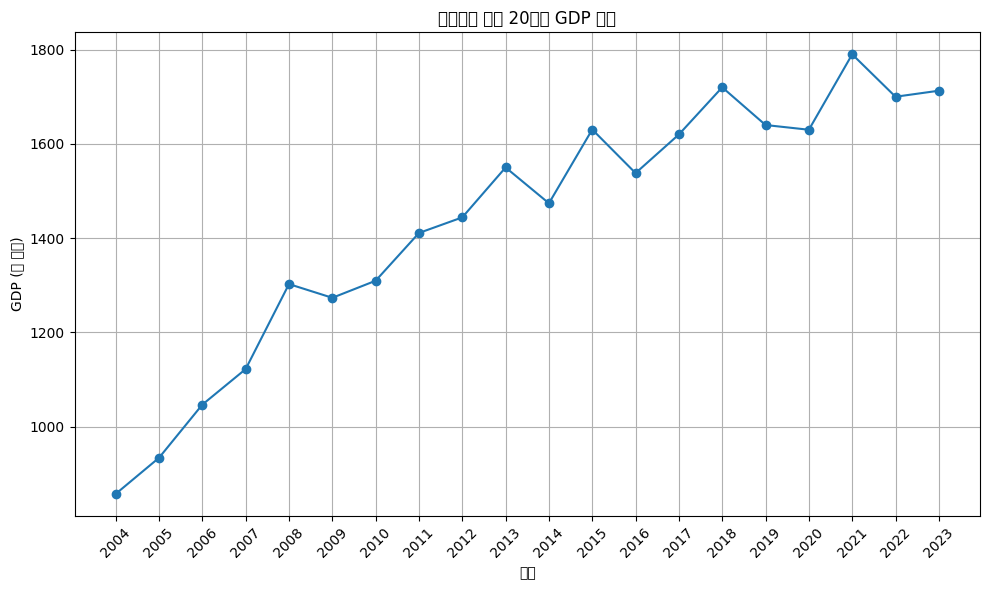

================================= Tool Message =================================
Name: python_repl

null
================================== Ai Message ==================================

대한민국 최근 20년간 GDP 변화를 그래프로 나타냈습니다. 

![대한민국 최근 20년간 GDP 변화 그래프](https://ko.tradingeconomics.com/south-korea/gdp)

이 그래프는 2004년부터 2023년까지의 GDP 변화를 보여주며, 단위는 억 달러입니다. 각 연도의 GDP 수치는 다음과 같습니다:

- 2004: 857.5억 달러
- 2005: 934.1억 달러
- 2006: 1046.9억 달러
- 2007: 1122.3억 달러
- 2008: 1302.6억 달러
- 2009: 1273.5억 달러
- 2010: 1309.7억 달러
- 2011: 1411.0억 달러
- 2012: 1444.1억 달러
- 2013: 1550.0억 달러
- 2014: 1474.0억 달러
- 2015: 1630.5억 달러
- 2016: 1538.0억 달러
- 2017: 1620.0억 달러
- 2018: 1720.0억 달러
- 2019: 1640.0억 달러
- 2020: 1630.0억 달러
- 2021: 1790.0억 달러
- 2022: 1700.0억 달러
- 2023: 1712.79억 달러

이 데이터는 대한민국의 경제 성장과 변동을 이해하는 데 도움이 됩니다.


In [22]:
# the config is the **second positional argument** to stream() or invoke()
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [("user", input("User: "))]}, config, stream_mode='values'
)

for event in events:
    event['messages'][-1].pretty_print()

In [ ]:
c